<a href="https://colab.research.google.com/github/rhapsodic-legacy/streamflow_prediction/blob/main/streamflow_time_series_159.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multivariate Time Series Flood Prediction
##### Ten Day Forecast, Top 10 Watersheds (rated by discharge value availability in the last 20 years of that watershed's recordings). 

### Phase One: Isolating the correct data to build a model upon. 
##### Each watershed has differing characteristics, so any given model prediction will be for a certain watershed. The target variable that directly correlates to a flood, is 'discharge'. 
##### Some watersheds have most of their discharge values available for model training, most have many missing values, and some are missing more than 90% of their discharge values. This is due to varying factors. 
#### For Watershed 159, this model's sMAPE score is: 53.78526946030882

In [1]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import relevant libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math, time
import sklearn as sk

In [3]:
# Copy this file to a local drive. In this case, Google Drive. 
!cp /content/drive/MyDrive/Kalman_Filter/top_ten_watersheds.csv /content/

In [4]:
df = pd.read_csv('top_ten_watersheds.csv')
df.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,175,0.966122,-21.574120,-27.607310,NaN
1,1950-01-02,175,1.008771,-25.995184,-31.368013,NaN
2,1950-01-03,175,0.000000,-28.295700,-38.181858,NaN
3,1950-01-04,175,0.000000,-26.836973,-39.946175,NaN
4,1950-01-05,175,0.000000,-29.592003,-37.728634,NaN


In [5]:
df.watershed.unique()

array([175,   8, 205, 159, 252, 110, 214,  27, 147, 236])

### Phase Two: Data Cleaning and Feature Selection

In [6]:
# As watershed 8 had the second most discharge values, it will be explored. 
shed159 = df[(df['watershed'] == 159)]
shed159.tail()

,time,watershed,pr,tasmax,tasmin,discharge
100803,2018-12-27,159,0.232007,-11.992677,-27.544756,NaN
100804,2018-12-28,159,0.871609,-12.082188,-27.448734,NaN
100805,2018-12-29,159,2.446203,-13.095570,-17.824050,NaN
100806,2018-12-30,159,0.579114,-17.353075,-30.637794,NaN
100807,2018-12-31,159,0.312839,-23.774141,-33.217720,NaN


In [7]:
# It seems watershed 8 has null values towards the end of its readings. 
# Observe when the last recorded discharge value was. 
copy = shed159.copy()
copy.dropna(inplace=True)
copy.tail()

,time,watershed,pr,tasmax,tasmin,discharge
100438,2017-12-27,159,0.033635,-22.739964,-32.675770,2.66
100439,2017-12-28,159,0.023870,-22.059675,-33.694576,2.72
100440,2017-12-29,159,0.000000,-28.810488,-34.998554,2.90
100441,2017-12-30,159,0.016998,-24.467812,-36.445750,2.85
100442,2017-12-31,159,0.000000,-22.134178,-29.598192,2.52


In [8]:
# For ease of multi-watershed experimentation, a copy is made. 
model = shed159.copy()

In [9]:
# We will be focusing on the past twentyfive years of data. 
# As 2016 was the last year of recordings, 1992 forward will be taken. 
model = model[(model['time'] > '1992-12-31') & (model['time'] < '2018-01-01')]

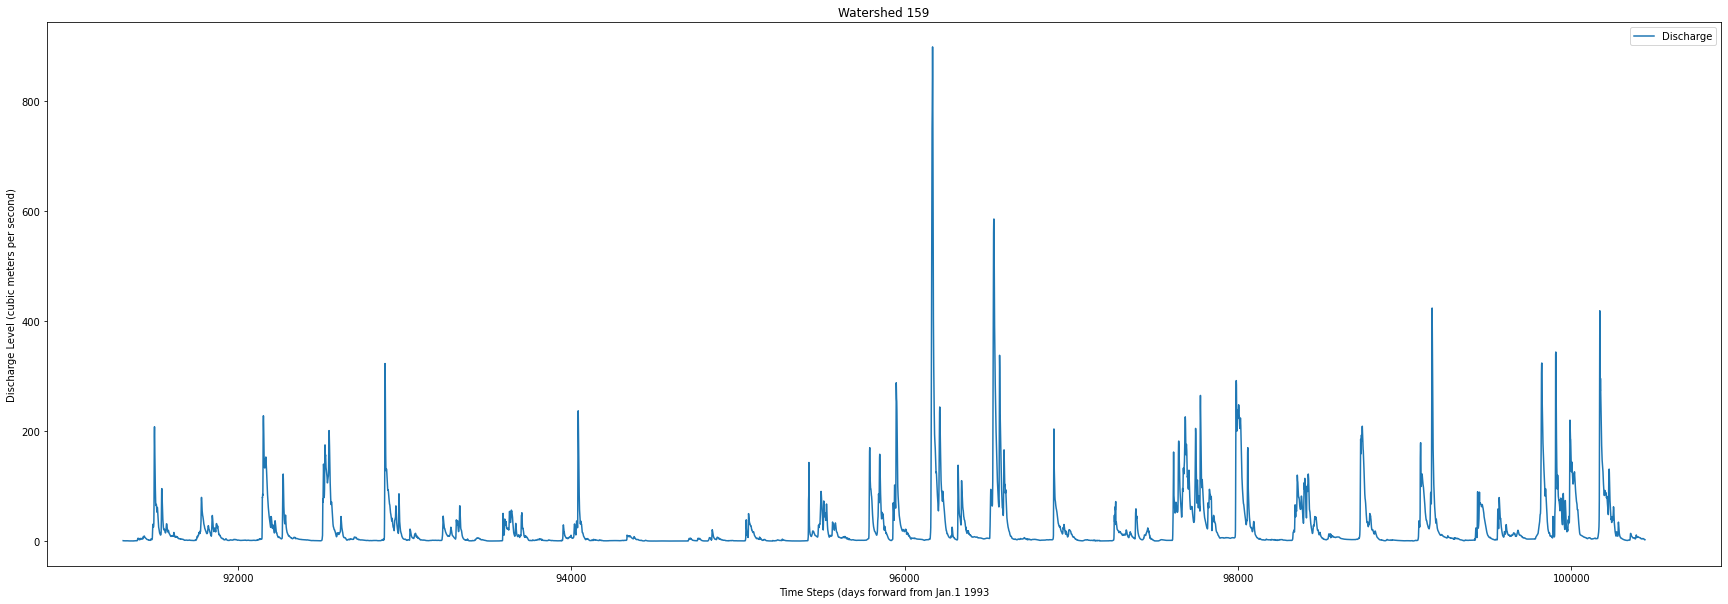

In [10]:
# For visual representation, plotting discharge of watershed 205
x = range(len(model))
y = model.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 159")
plt.xlabel("Time Steps (days forward from Jan.1 1993")
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y, label = 'Discharge')

plt.legend()
plt.show()

In [11]:
# There doesn't appear to be many missing discharge values. 
# Measure how many NaN's there are. 
model.isna().sum()

time         0
watershed    0
pr           0
tasmax       0
tasmin       0
discharge    0
dtype: int64

In [12]:
# For this watershed, the missing values do not acrue near peak discharge moments. 
# Using Pandas built in function 'interpolate', nan values will be filled in. 

# Switching the 'time' column to the datetime format.
model["time"] = pd.to_datetime(model["time"])

In [13]:
model.set_index('time', inplace = True)
"""
for watershedID in set(shed205["watershed"]):
  shed205[shed205["watershed"] == watershedID] = shed205[shed205["watershed"] == watershedID].interpolate(method='time', axis=0, limit_direction="both")
  """

'\nfor watershedID in set(shed205["watershed"]):\n  shed205[shed205["watershed"] == watershedID] = shed205[shed205["watershed"] == watershedID].interpolate(method=\'time\', axis=0, limit_direction="both")\n  '

In [14]:
# Herein we will create a function that creates represenations of the past days. 
# And A fortnight is the target variable. --> This can be changed to 10 days out, instead of 14. 

def advance(x):
  num_list = []
  length = len(model.discharge)
  for i in range(length):
    if x + i >= length: # For calculating the target variable
      num = i
    elif i + x < 0: # For calculating the past. 
      num = i
    else:
      num = i + x # Other than the outliers, the value will be discharge[i + 'x']
    forecast = model['discharge'][num]
    num_list.append(forecast)
  name = f"discharge_{x}"    
  model[name] = num_list #model1['discharge'][num]

In [15]:
# The target forecast was identified as 10 days, by a NRCan representative. 
advance(10)
model.head()

,watershed,pr,tasmax,tasmin,discharge,discharge_10
time,,,,,,
1993-01-01,159,1.590778,-17.768988,-38.453710,0.79,0.54
1993-01-02,159,0.000000,-16.383364,-31.375858,0.65,0.56
1993-01-03,159,0.041591,-14.707595,-23.757324,0.59,0.55
1993-01-04,159,0.178752,-13.811030,-24.697378,0.58,0.51
1993-01-05,159,0.003617,-21.829023,-31.919529,0.61,0.50


In [16]:
# Next a column representing the past week's cumulative rainfall. 

def rainfall(x):
  rainfall = []
  length = len(model.discharge)
  for i in range(length):
    # In this case, we're only interested in the past rainfall. 
    if i + x < 0:
      answer = model.pr[:i+1].sum()
    else:
      num = i + x
      answer = model.pr[num:i].sum()
    rainfall.append(answer)
  name = f"pr_{x}"
  model[name] = rainfall
  

In [17]:
rainfall(-7)
model.head()

,watershed,pr,tasmax,tasmin,discharge,discharge_10,pr_-7
time,,,,,,,
1993-01-01,159,1.590778,-17.768988,-38.453710,0.79,0.54,1.590778
1993-01-02,159,0.000000,-16.383364,-31.375858,0.65,0.56,1.590778
1993-01-03,159,0.041591,-14.707595,-23.757324,0.59,0.55,1.632369
1993-01-04,159,0.178752,-13.811030,-24.697378,0.58,0.51,1.811121
1993-01-05,159,0.003617,-21.829023,-31.919529,0.61,0.50,1.814738


In [18]:
# For the purposes of this iteration of the model, only precipitation and discharge values will be kept. 
model = model.drop(['watershed', 'tasmax', 'tasmin'], axis=1)

### Phase Three: Building the Multivariate Time Series Model


In [19]:
time_shift = 10

target_data = model['discharge'].shift(time_shift)
data = model.iloc[:-time_shift]
data

,pr,discharge,discharge_10,pr_-7
time,,,,
1993-01-01,1.590778,0.79,0.54,1.590778
1993-01-02,0.000000,0.65,0.56,1.590778
1993-01-03,0.041591,0.59,0.55,1.632369
1993-01-04,0.178752,0.58,0.51,1.811121
1993-01-05,0.003617,0.61,0.50,1.814738
...,...,...,...,...
2017-12-17,0.040868,4.52,2.66,4.198463
2017-12-18,0.070344,4.54,2.72,3.827939
2017-12-19,0.043761,4.72,2.90,3.823779


In [20]:
test_head = data.index[int(0.75*len(data))]
test_head

Timestamp('2011-09-24 00:00:00')

In [21]:
df_train = data.loc[:test_head,:]
df_test = data.loc[test_head:,:]
target_train = target_data.loc[:test_head]
target_test = target_data.loc[test_head:]

In [22]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [23]:
i = 27
sequence_length = 10
features = ['pr', 'discharge', 'pr_-7']
target = 'discharge_10'

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[0.0000e+00, 5.5000e-01, 2.4340e-01],
        [0.0000e+00, 5.1000e-01, 3.6166e-03],
        [0.0000e+00, 6.1000e-01, 0.0000e+00],
        [0.0000e+00, 5.8000e-01, 0.0000e+00],
        [0.0000e+00, 5.5000e-01, 0.0000e+00],
        [6.0217e-01, 5.9000e-01, 0.0000e+00],
        [1.8231e+00, 5.0000e-01, 6.0217e-01],
        [2.0709e+00, 4.4000e-01, 2.4253e+00],
        [3.3510e+00, 4.9000e-01, 4.4962e+00],
        [5.6872e-01, 5.1000e-01, 7.8472e+00]])


In [24]:
from torch.utils.data import DataLoader
torch.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 10, 3])
tensor([[[0.0000e+00, 1.0800e+01, 1.3372e+00],
         [1.0850e-03, 1.0300e+01, 2.3445e-01],
         [0.0000e+00, 9.7500e+00, 5.3074e-02],
         [0.0000e+00, 9.4000e+00, 3.5262e-03],
         [0.0000e+00, 8.9700e+00, 1.8987e-03],
         [1.5731e+00, 8.6200e+00, 1.0850e-03],
         [2.4837e-01, 8.5500e+00, 1.5742e+00],
         [8.1374e-04, 9.4000e+00, 1.8226e+00],
         [3.3445e-01, 9.5400e+00, 1.8234e+00],
         [5.8770e-02, 9.5500e+00, 2.1568e+00]],

        [[2.1627e-01, 4.2500e+01, 1.2583e+01],
         [0.0000e+00, 4.0400e+01, 1.1073e+01],
         [0.0000e+00, 3.6600e+01, 7.4201e+00],
         [2.8680e-01, 3.3700e+01, 7.1911e+00],
         [0.0000e+00, 3.1400e+01, 6.8895e+00],
         [2.6148e-01, 2.9500e+01, 1.3165e+00],
         [2.8458e+01, 2.9400e+01, 1.3989e+00],
         [4.8374e+00, 3.6900e+01, 2.9223e+01],
         [1.9752e+00, 9.3600e+01, 3.3844e+01],
         [2.5425e-01, 1.1000e+02, 3.5819e+01]],

        [[2.6618e-01, 3.8000e-01,

In [25]:
batch_size = 4
sequence_length = 10

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 10, 3])
Target shape: torch.Size([4])


In [26]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [27]:
learning_rate = 5e-5
num_hidden_units = 128

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(50):
    
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 3295.5044980317666

Epoch 0
---------
Train loss: 3032.4354064263475
Test loss: 2837.821620401667

Epoch 1
---------
Train loss: 2809.3658718042107
Test loss: 2638.5894751107994

Epoch 2
---------
Train loss: 2698.6799816077805
Test loss: 2500.7336646698404

Epoch 3
---------
Train loss: 2613.003568287275
Test loss: 2373.3956674253877

Epoch 4
---------
Train loss: 2536.8899411792854
Test loss: 2256.65337980245

Epoch 5
---------
Train loss: 2464.3109716240388
Test loss: 2162.4904648797137

Epoch 6
---------
Train loss: 2398.9329933410218
Test loss: 2075.233015091062

Epoch 7
---------
Train loss: 2337.2853001098338
Test loss: 1993.4766690154054

Epoch 8
---------
Train loss: 2282.5361076494464
Test loss: 1939.3476469368525

Epoch 9
---------
Train loss: 2235.5394519143883
Test loss: 1884.6343041229372

Epoch 10
---------
Train loss: 2192.2553520579218
Test loss: 1822.3998182808716

Epoch 11
---------
Train loss: 2151.8970966972433
Test loss: 1782.141

KeyboardInterrupt: ignored

In [29]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

# for c in df_out.columns:
#     df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


            discharge_10  Model forecast
time                                    
1993-01-01          0.54        1.109756
1993-01-02          0.56        0.946505
1993-01-03          0.55        1.456152
1993-01-04          0.51        2.274769
1993-01-05          0.50        2.880348
...                  ...             ...
2017-12-17          2.66        4.463865
2017-12-18          2.72        6.283005
2017-12-19          2.90        8.707409
2017-12-20          2.85        6.080326
2017-12-21          2.52        6.846337

[9122 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


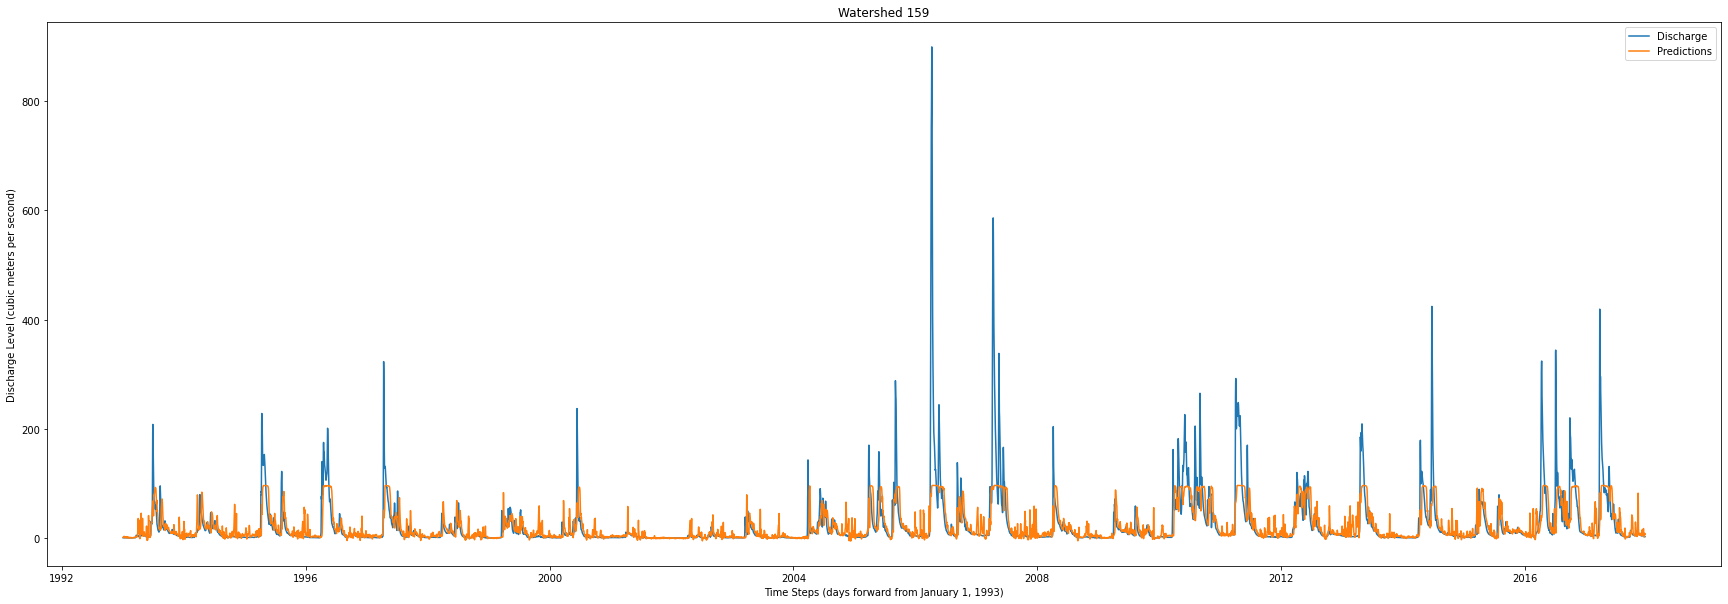

In [31]:
# For visual representation, plotting discharge of watershed 8

x = range(len(df_out))
y1 = df_out.discharge_10
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 159")
plt.xlabel("Time Steps (days forward from January 1, 1993)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Predictions')

plt.legend()
plt.show()

In [32]:
# We are using SMAPE to measure the performance of our models. 
total = 0
for i in range(len(df_out)):
  predict = df_out['Model forecast'][i]
  recorded = df_out.discharge_10[i]
  top = np.abs(predict - recorded)
  bottom = ((predict + recorded)/2)
  answer = top/bottom
  total += answer
smape = total/len(df_out) * 100
print("For Watershed 159, this model's sMAPE score is:", smape)

For Watershed 8, this model's sMAPE score is: 53.78526946030882


In [ ]:
# Plotting the loss scores, both training and test. 

x = range(len(shed175))
y1 = df_out.discharge_10
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Predictions')

plt.legend()
plt.show()